# Modelovanie č. 1 - klasifikačné metódy


## Načítanie knižníc

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## Načítanie dát

In [11]:
with open('data/Train_data_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

## Rozdelenie dát na trénovacie a testovacie

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['class']), data['class'], test_size=0.3, random_state=42)

## Normalizácia dát pomocou StandardScaler

In [13]:
quantitative = ['src_bytes', 'dst_bytes', 'hot', 'count', 'serror_rate', 'rerror_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[quantitative])
X_test = scaler.transform(X_test[quantitative])

## Modelovanie

In [14]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

models = (
    ('Logistická regresia', lr),
)

## Vyhodnotenie modelov

Logistická regresia Specificity: 0.9588
Logistická regresia Accuracy: 0.9508
{'Normal': {'precision': 0.9587572174869398, 'recall': 0.9444745395449621, 'f1-score': 0.9515622868058398, 'support': 3692.0}, 'Anomaly': {'precision': 0.942641298265249, 'recall': 0.9573742540494459, 'f1-score': 0.94995065557592, 'support': 3519.0}, 'accuracy': 0.9507696574677575, 'macro avg': {'precision': 0.9506992578760944, 'recall': 0.950924396797204, 'f1-score': 0.9507564711908798, 'support': 7211.0}, 'weighted avg': {'precision': 0.9508925773897092, 'recall': 0.9507696574677575, 'f1-score': 0.9507758036137599, 'support': 7211.0}}


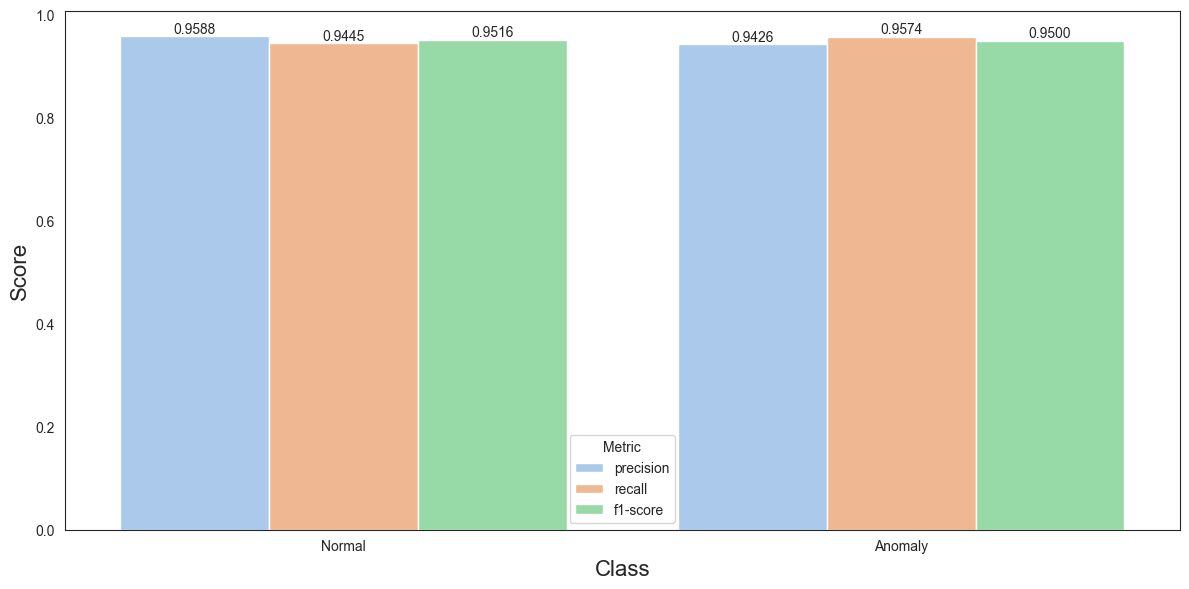

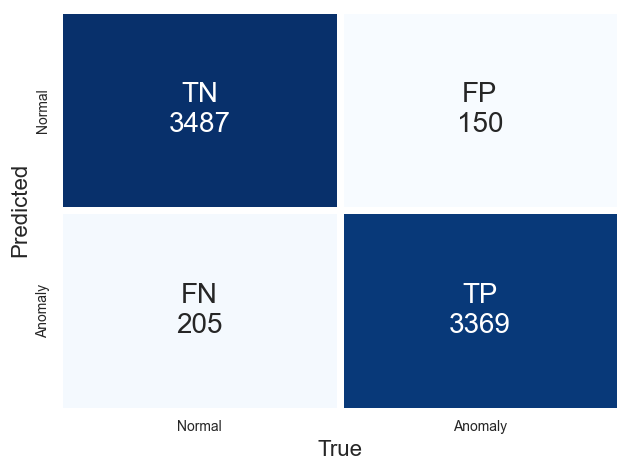

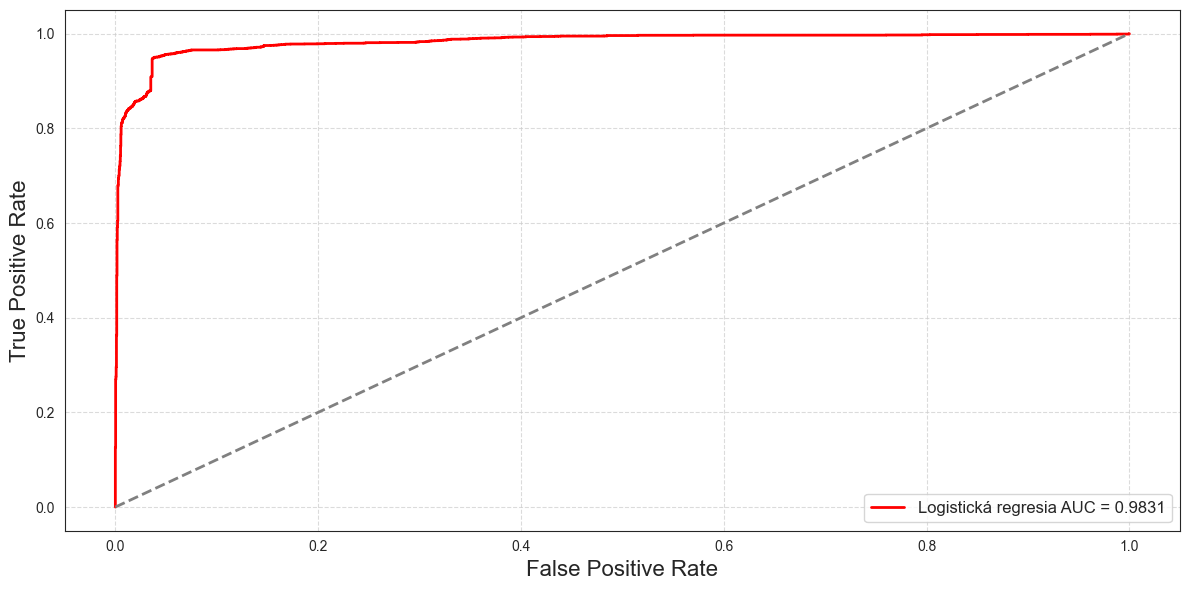

In [15]:
sns.set_style("white")

target_names = ["Normal", "Anomaly"]

for name, model in models:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred).T 
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    print(f"{name} Specificity: {specificity:.4f}")
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    print(report)
    report_df = pd.DataFrame(report).transpose().reset_index()

    report_melted = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='metric', value_name='score')
    report_melted = report_melted[~report_melted['index'].isin(['macro avg', 'weighted avg', 'accuracy'])]

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='index', y='score', hue='metric', data=report_melted, palette='pastel')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    #plt.title(f'Classification Report of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Score', fontsize=16)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig(f'{name}_report_before_GS.png')
    plt.show()

for name, model in models:
    cm = confusion_matrix(y_test, model.predict(X_test)).T
    tn, fp, fn, tp = cm.ravel()
    annot = [[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']]

    sns.heatmap(cm, annot=annot, cmap='Blues', linewidths=5, fmt='', xticklabels=target_names, yticklabels=target_names, cbar=False, annot_kws={'size': 20})
    #plt.title(f'CM of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('True', fontsize=16)
    plt.ylabel('Predicted', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{name}_cm_before_GS.png')
    plt.show()

for name, model in models:
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, label=f'{name} AUC = {roc_auc:.4f}', color='red', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    #plt.title(f'ROC curve of {name}', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{name}_roc_before_GS.png')
    plt.show()

In [16]:
X_train = data.drop(columns=['class'])
y_train = data['class']

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[quantitative])

for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print(f"{name} Cross Validation Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Logistická regresia Cross Validation Accuracy: 0.9543 (+/- 0.0058)


In [17]:
param_grids = {
    'Logistická regresia': {
        "penalty": ["l1", "l2", "elasticnet", "none"],
        "C": [0.01, 0.1, 1],
        "solver": ["liblinear", "lbfgs", "sag", "saga", "newton-cg"],
        'max_iter': [500, 1000, 1500, 2000, 2500]
    },
}

best_models = {}

for name, model in models:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=10, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {name}: {grid_search.best_score_:.4f}")

for name, model in best_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print(f"{name} Cross Validation Accuracy with best parameters: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


c:\Users\kuruc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1950 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kuruc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kuruc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\kuruc\AppData\Local\Programs\Python\Python310\lib\site-pa

Best parameters for Logistická regresia: {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy for Logistická regresia: 0.9553
Logistická regresia Cross Validation Accuracy with best parameters: 0.9552 (+/- 0.0050)


## Holdout validácia po optimalizácii hyperparametrov

Logistická regresia Specificity: 0.9596
Logistická regresia Accuracy: 0.9523
{'Normal': {'precision': 0.9596375617792422, 'recall': 0.9466413867822319, 'f1-score': 0.9530951731660758, 'support': 3692.0}, 'Anomaly': {'precision': 0.9448024656766602, 'recall': 0.9582267689684569, 'f1-score': 0.9514672686230248, 'support': 3519.0}, 'accuracy': 0.952295104701151, 'macro avg': {'precision': 0.9522200137279512, 'recall': 0.9524340778753444, 'f1-score': 0.9522812208945504, 'support': 7211.0}, 'weighted avg': {'precision': 0.9523979690480001, 'recall': 0.952295104701151, 'f1-score': 0.9523007485249725, 'support': 7211.0}}


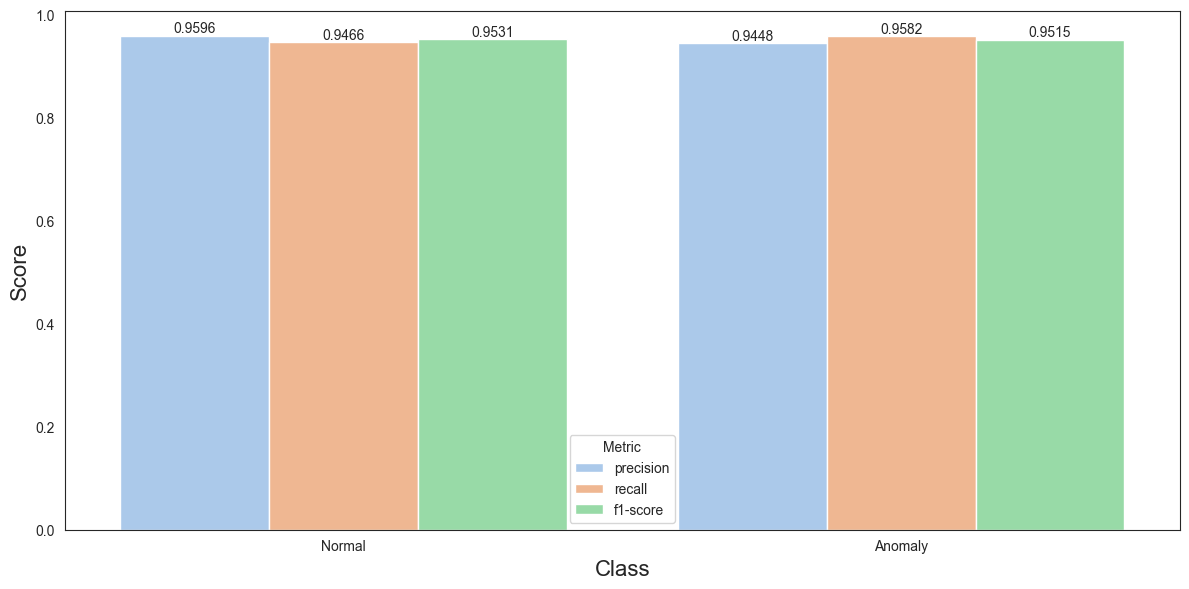

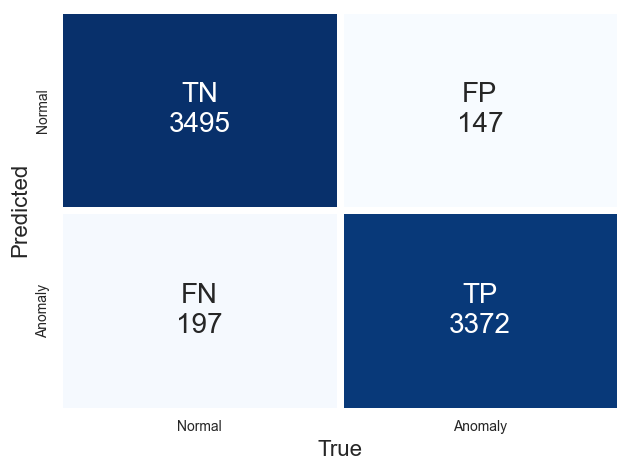

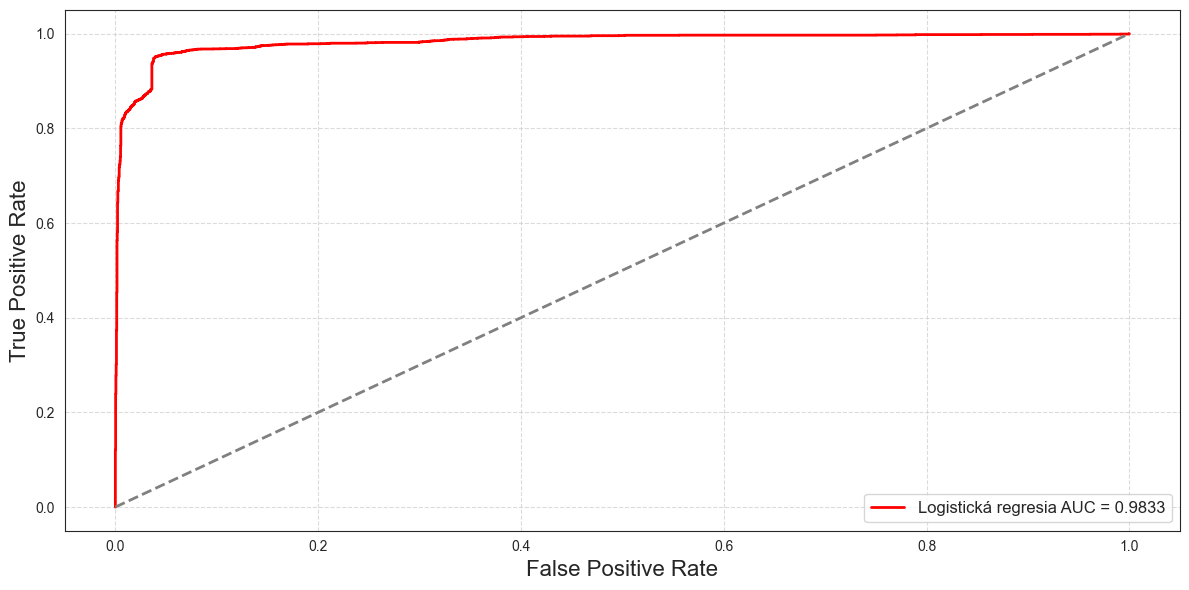

In [18]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred).T
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    print(f"{name} Specificity: {specificity:.4f}")
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    print(report)
    report_df = pd.DataFrame(report).transpose().reset_index()

    report_melted = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='metric',
                                   value_name='score')
    report_melted = report_melted[~report_melted['index'].isin(['macro avg', 'weighted avg', 'accuracy'])]

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='index', y='score', hue='metric', data=report_melted, palette='pastel')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    #plt.title(f'Classification Report of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Score', fontsize=16)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig(f'{name}_report_after_GS.png')
    plt.show()

for name, model in best_models.items():
    cm = confusion_matrix(y_test, model.predict(X_test)).T
    tn, fp, fn, tp = cm.ravel()
    annot = [[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']]

    sns.heatmap(cm, annot=annot, cmap='Blues', linewidths=5, fmt='', xticklabels=target_names, yticklabels=target_names,
                cbar=False, annot_kws={'size': 20})
    #plt.title(f'CM of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('True', fontsize=16)
    plt.ylabel('Predicted', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{name}_cm_after_GS.png')
    plt.show()

for name, model in best_models.items():
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, label=f'{name} AUC = {roc_auc:.4f}', color='red', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    #plt.title(f'ROC curve of {name}', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{name}_roc_after_GS.png')
    plt.show()
